In [ ]:
### EEGNet() w/PyTorch
# Utsav Dutta, Medical Intelligence and Language Engineering Lab
# IISc Bangalore

In [ ]:
# Import relevant PyTorch libraries

import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
## Define a Dataset class module

'''
  - Root: Define root folder containing data in the form of the following:
  /Class1
    -S1
    -S2
    -S3..
  /Class2
    -S1
    -S2
    -S3..
  where each class contains the same subjects.

  - Index Map: 
    Mapping function from integer (0 to N), to [class,subject] mapping. 
    The helper function 'return_index' returns this mapping as a dictionary

  - __getitem__:
    Lazy load file when called for. Maps index to [class,subject] to build path.
    Epoching of data is done WITHIN getitem and returns a tuple of sizes:
    X -> [N_epochs,Channels,Times], Y -> [N_epochs, Labels]
    
    We define a custom_collate function to concatenate getitem calls instead of
    stacking on first dimension as done by PyTorch's default mechanism.

'''
class EEGDataset(Dataset):

  # Define self variables
  def __init__(self,root = '/content/drive/MyDrive/med_data/'):
    
    self.root = root
    self.index_map = {}
    self.index_map_out = {}

    # Create index map for __getitem__

    index = 0
    for state in os.listdir(self.root):
      for path in os.listdir(self.root + state + '/'):

        self.index_map[index] = (state,path)
        self.index_map_out[index] = (state,path[:3])

        index = index + 1
    
    self.length = index
    # For eg, self.index_map[0] = (state,path)
 
  # Define len method
  def __len__(self):
    
    return self.length

  # Define get_item method
  def __getitem__(self,index):

    state,path = self.index_map[index]
    combined_path = self.root + state + '/' + path

    # Load data into __getitem__
    data = np.loadtxt(combined_path).T
    
    # Epoch and stack data
    arr = []

    n_seconds = 1
    for start in range(0,data.shape[1],128*n_seconds):
    
      if start + 128*n_seconds < data.shape[1]:
        arr.append(data[:,start:start + 128*n_seconds])

    # Convert to array, dimensions [n_samples,channels,time]
    X = np.array(arr)
    Y = [(state,path[:3])]*X.shape[0]

    sample = (torch.from_numpy(X),Y)

    return sample

  # Helper function to return indexes
  def return_index(self):

    return self.index_map_out

In [ ]:
subjects = [subject for state,subject in EEGDataset().return_index().values()]
states = [state for state,subject in EEGDataset().return_index().values()]

In [ ]:
from torch.utils.data.sampler import Sampler
import random

## Create Custom Train Test Samplers

'''

  For EEG data, we create a custom train,test sampler which takes indices 
  corresponding to only one subject as test, and rest as train. The samplers are
  then used to train on all subjects barring one.
  The samplers retain indices corresponding to the values in index_map

'''

def create_samplers(dataset,leave_out_subject):

  # Create a sampler over training indices, based on index values

  class TrainSampler(Sampler):

    def __init__(self,dataset,batch_size,leave_out_subject = leave_out_subject):

      self.indexes = dataset.return_index()
      self.train_indices = [key for key,value in self.indexes.items() if value[1] != leave_out_subject]
    
    def __iter__(self):
      random.shuffle(self.train_indices)
      
      return iter(self.train_indices)
    
    def __len__(self):

      return len(self.train_indices)
  
  # Create a sampler over test indices, based on index values

  class TestSampler(Sampler):

    def __init__(self,dataset,batch_size,leave_out_subject = leave_out_subject):

      self.indexes = dataset.return_index()
      self.test_indices = [key for key,value in self.indexes.items() if value[1] == leave_out_subject]
    
    def __iter__(self):
      random.shuffle(self.test_indices)
      
      return iter(self.test_indices)
    
    def __len__(self):

      return len(self.test_indices)
  
  return TrainSampler(dataset,leave_out_subject),TestSampler(dataset,leave_out_subject)

In [ ]:
# Custom Collate Function, stacks batches by concatenating along batch_dimension directly

def custom_collate(batch):

  X = [sample[0] for sample in batch]
  Y = [sample[1] for sample in batch]
  X = np.concatenate(X,axis = 0)
  Y = np.concatenate(Y)

  return torch.from_numpy(X),Y

In [ ]:
## First CONV Block - Temporal
'''
  Takes multivariate time series of the form [Channels,Timestamps] 
  Applies channelwise convolution to each time series, with n_filters = 10,
  for each time series, given output of [Channels, n_filters, Timestamps_new]

  Things to check : Number of Filters, Length fo Filter, LeakyReLU
'''

class Multiple1DTemporalBlock(nn.Module):

  def __init__(self, channels = 61, conv_channels = 10, kernel_size = 60):
    super().__init__()

    self.channels = channels
    self.Conv1DLayers = nn.ModuleList()

    # Create a Conv1D filter for each time series

    for channel in range(self.channels):

      self.Conv1DLayers.append(
          nn.Conv1d(in_channels = 1, 
                    out_channels = conv_channels, 
                    kernel_size = kernel_size,
                    stride = 1,
                    padding = 1)
          )

  def forward(self,x):

    out = []

    for channel in range(self.channels):
      
      x_channel = x[:,[channel],:]
      out.append(self.Conv1DLayers[channel](x_channel))
    
    # Stack on new dimension, output is 4D matrix
    out = torch.stack(out, dim = 1)

    # Pass through ReLU
    out = F.leaky_relu(out,0.01)

    return out

In [ ]:
## Second CONV Block - Spatial

'''
  Input from previous CONV block is of the form [Channels,Filters,Timestamps] 
  We wish to now compute filters to derive spatial features across channels.
  This data can then be fed through further convolutions or into an LSTM.

  We create a new 'channels' dimension, as required by pytorch and pass in 
  kernels of the shape (61,10,1) which are passed along the time axis (455).
  We pass n_filters = 15 kernels like so, and squeeze the output back to
  [Filters, Timestamps]

'''

class SpatialConvBlock(nn.Module):

  def __init__(self):
    super().__init__()

    # We use a conv1d filter and each convolution
    # is on the entire spatial dimension at time t.
    
    self.conv1 = nn.Conv1d(
        in_channels = 1, out_channels = 5, kernel_size = (61,10,1)
    )

  def forward(self,x):

    # Perform unsqueeze and squeeze to convert to requisite dimensions

    # [None,1,61,10,455]
    x = torch.unsqueeze(x, dim = 1)

    # [None,15,1,1,455]
    x = self.conv1(x)
    x = F.leaky_relu(x,0.01)

    x = torch.squeeze(x)

    return x

In [ ]:
## Linear Layer

'''
  Create fully connected layers.
  Variable number of layers and sizes.
  Input dimensions -> [batch, channels, steps]

'''
class LinearLayers(nn.Module):

  def __init__(self,layer_sizes):
    super().__init__()

    self.num_layers = len(layer_sizes)

    self.layerlist = nn.ModuleList()

    for i in range(self.num_layers):

      self.layerlist.append(nn.LazyLinear(layer_sizes[i]))
    
    self.fc = nn.LazyLinear(2)
  
  def forward(self,x):

    x = x.view(x.shape[0],-1)

    for i in range(self.num_layers):

      x = self.layerlist[i](x)
      x = F.leaky_relu(x, 0.01)

    x = self.fc(x)
    
    return x

In [ ]:
## Combine all models into a pipeline

class EEGModel(nn.Module):

  def __init__(self) :
    super().__init__()

    self.conv_temp = Multiple1DTemporalBlock()
    self.conv_spat = SpatialConvBlock()
    self.linear_model = LinearLayers([1024,512])

  def forward(self,x):

    x = self.conv_temp(x)

    x = self.conv_spat(x)

    x = self.linear_model(x)

    return x

In [ ]:
## Helper Function for visualizing gradient flow
# Use for debugging inside train loop

from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):

    '''
      Plots the gradients flowing through different layers in the net during training.
      Can be used for checking for possible gradient vanishing / exploding problems.
      
      Usage: Plug this function in Trainer class after loss.backwards() as 
      "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow
    '''

    ave_grads = []
    max_grads= []
    layers = []

    for n, p in named_parameters:

        if(p.requires_grad) and ("bias" not in n):

            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )

    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

In [ ]:
def train_model(model,optimizer,subject_id,dataset = EEGDataset(), epochs = 500, batch_size = 32):

  '''
    Defines the training block.

    Inputs: 
      model for evaluation.
      dataset.
      epochs.
      subject_id for test.
      batch_size for sampler.

    The model is first trained ONLY using trainloader. All subjects except for
    the test subject
    

  '''

  # Load stratified data samplers
  train_sampler, test_sampler = create_samplers(dataset,subject_id)

  # Load PyTorch dataloader objects  
  trainloader = DataLoader(dataset, sampler = train_sampler, 
                           batch_size = batch_size, collate_fn = custom_collate)
  testloader = DataLoader(dataset, sampler = test_sampler, 
                          batch_size = batch_size, collate_fn = custom_collate)

  # Push model to GPU
  device = 'cuda'

  model = model.to(device = device)
  dtype = torch.float32

  # Define loss function
  loss = nn.CrossEntropyLoss()

  # Empty variable to collect loss over time
  losses = []

  ### Train Block

  # Iterate over train loop
  for epoch in range(epochs):

    print('Epoch Number = ' + str(epoch))

    for t,(x,y) in enumerate(trainloader):
      
      # model in training mode
      model.train()

      # Push data,targets to GPU
      x = x.to(device = device, dtype = dtype)
      x = x.float()

      # Convert labels to LongTensor format
      y = torch.LongTensor([1 if state == 'med' else 0 for state in y[:,0]])
      y = y.to(device = device)

      # Compute class scores (Nx2) array
      scores = model(x)
      
      # Visualize confusion matrix, use detach() to extract PyTorch tensor as 
      # a numpy object
      print(pd.crosstab(np.argmax(scores.cpu().detach().numpy(),axis = 1),
                        y.cpu().detach().numpy(), rownames = ['pred'], 
                        colnames = ['true']))
      
      # Compute loss
      # NOTE: Here, we use a weighted loss function to account for class imbalance
      loss = nn.CrossEntropyLoss(weight = torch.FloatTensor([0.2 , 0.8]).cuda())(scores,y)

      # Append loss of current iter to total losses
      losses.append(loss)

      # Set all grads to zero
      optimizer.zero_grad()

      # Compute all backward gradients
      loss.backward()

      # Visualize backwards gradients
      plot_grad_flow(model.named_parameters())

      # Compute new weights
      optimizer.step()

      # Print iter loss
      print('loss = ',round(loss.item(),2))
      print('\n')

    # Visualize complete training loss
    plt.plot(losses)
    plt.show()

  ## Test Loop

  # Compute predictions over test data (loaded in batches due to memory constraint)
  
  accuracy = []

  # Iterate over testloader
  for t,(x_test,y_test) in enumerate(testloader):
    
    # Set model to eval mode
    model.eval()

    # Push data,targets to GPU
    x_test = x_test.to(device = device, dtype = dtype)
    x_test = x_test.float()

    # Convert labels to LongTensor format
    y_test = torch.LongTensor([1 if state == 'med' else 0 for state in y_test[:,0]])
    y_test = y_test.to(device = device)

    # Compute test scores
    test_scores = model(x_test)
    
    # Append accuracy of epoch to accuracy list
    accuracy.append(np.mean(np.argmax(scores.cpu().detach().numpy(),axis = 1) == y_test.cpu().detach().numpy()))

  print(accuracy,np.mean(accuracy))

In [ ]:
## Helper function to run model

  '''
    Adam optimizer used by default. Specify changes to optimizer within function call
    run_model takes in subject id of the form '101','102'...etc. to analyze 
    subject wise performance. The custom trainloaders take train data as all
    subjects other than the subject id and test loaders take all data only
    belonging to subject id.
  '''

def run_model(subject_id, batch_size = 4):

  model = EEGModel()
  optimizer = torch.optim.Adam(model.parameters())
  batch_size = batch_size

  train_model(model,optimizer,subject_id,batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch Number = 0
true   0
pred    
0     73
1     18
loss =  0.64


true   0    1
pred         
0     67  591
loss =  10.95


true   0    1
pred         
0     78  217
loss =  6.21


true   0    1
pred         
1     80  309
loss =  0.65


true    0
pred     
1     120
loss =  1.04


true   0
pred    
1     80
loss =  1.11


true    0
pred     
0      17
1     133
loss =  0.72


true   0     1
pred          
0     32  1005
1      0    84
loss =  1.06


true   0    1
pred         
0     99  243
1      3   17
loss =  1.06


true    0
pred     
0     133
loss =  0.37


true   0    1
pred         
0     67  663
1      0    1
loss =  1.23


true   0
pred    
0     94
1     13
loss =  0.55


true   0    1
pred         
0     85  218
1      6    6
loss =  0.9


true   0    1
pred         
0     36  253
1     24  135
loss =  0.72


true   0    1
pred         
1     64  306
loss =  0.66


true   0
pred    
1     95
loss =  0.78


true   0    1
pred         
1     63  190
loss =  0.64


true    

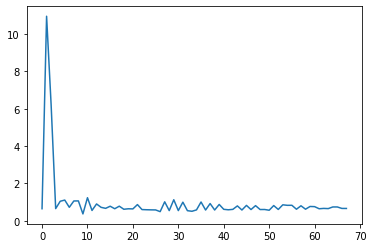

Epoch Number = 1
true   0    1
pred         
1     98  326
loss =  0.66


true   0    1
pred         
1     50  648
loss =  0.66


true   0    1
pred         
1     91  310
loss =  0.66


true   0    1
pred         
1     79  337
loss =  0.66


true    0
pred     
1     149
loss =  0.73


true   0    1
pred         
0      1    0
1     73  577
loss =  0.66


true    0
pred     
1     129
loss =  0.74


true   0    1
pred         
0      0    9
1     53  531
loss =  0.66


true   0    1
pred         
0      0   24
1     46  513
loss =  0.66


true   0    1
pred         
0      0    1
1     55  410
loss =  0.65


true   0    1
pred         
1     48  463
loss =  0.65


true   0    1
pred         
1     57  754
loss =  0.64


true   0    1
pred         
1     36  553
loss =  0.64


true   0
pred    
1     94
loss =  0.74


true   0
pred    
1     99
loss =  0.75


true   0    1
pred         
1     92  318
loss =  0.65


true   0    1
pred         
1     56  697
loss =  0.63


true   0    

In [ ]:
subject_id = '101'
model = EEGModel()
optimizer = torch.optim.Adam(model.parameters())
batch_size = 4

train_model(model,optimizer,subject_id,batch_size = batch_size)

In [ ]:
x = torch.rand